In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import random as rd

In [45]:
def get_distance(x1, x2):
    sum = 0
    for i in range(len(x1)):
        sum += (x1[i] - x2[i]) ** 2
    return np.sqrt(sum)


def kmeans(X, k, max_iters):
  
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]

    converged = False
    
    current_iter = 0

    while (not converged) and (current_iter < max_iters):

        cluster_list = [[] for i in range(len(centroids))]

        for x in X:  # Go through each data point
            distances_list = []
            for c in centroids:
                distances_list.append(get_distance(c, x))
            cluster_list[int(np.argmin(distances_list))].append(x)

        cluster_list = list((filter(None, cluster_list)))

        prev_centroids = centroids.copy()

        centroids = []

        for j in range(len(cluster_list)):
            centroids.append(np.mean(cluster_list[j], axis=0))

        pattern = np.abs(np.sum(prev_centroids) - np.sum(centroids))

        # print('K-MEANS: ', int(pattern))

        converged = (pattern == 0)

        current_iter += 1

    return np.array(centroids), [np.std(x) for x in cluster_list]

In [46]:
class RBF:

    def __init__(self, X, y, tX, ty, num_of_classes,
                 k, std_from_clusters=True):
        self.X = X
        self.y = y

        self.tX = tX
        self.ty = ty

        self.number_of_classes = num_of_classes
        self.k = k
        self.std_from_clusters = std_from_clusters

    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    def rbf(self, x, c, s):
        distance = get_distance(x, c)
        return  np.exp(-distance**2 / 2* s ** 2)

    def rbf_list(self, X, centroids, std_list):
        RBF_list = []
        for x in X:
            RBF_list.append([self.rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(RBF_list)

    def fit(self):

        self.centroids, self.std_list = kmeans(self.X, self.k, max_iters=100)

        if not self.std_from_clusters:
            dMax = np.max([get_distance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
            self.std_list = np.repeat(dMax / np.sqrt(2 * self.k), self.k)

        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.y, self.number_of_classes)

        RBF_list_tst = self.rbf_list(self.tX, self.centroids, self.std_list)

        self.pred_ty = RBF_list_tst @ self.w

        self.pred_ty = np.array([np.argmax(x) for x in self.pred_ty])

        diff = self.pred_ty - self.ty

        print('Accuracy: ', len(np.where(diff == 0)[0]) / len(diff))

        return self.pred_ty

In [47]:
data=pd.read_csv('iris.csv')

In [48]:
columns_value = ['sepal length (cm)',	'sepal width (cm)'	,'petal length (cm)',	'petal width (cm)','target']
dataset = data.values
dataset = pd.DataFrame(dataset,columns=columns_value)

In [49]:
dataset ['sepal length (cm)'] = dataset ['sepal length (cm)'].astype(np.float64)
dataset ['sepal width (cm)'] = dataset ['sepal width (cm)'].astype(np.float64)
dataset ['petal length (cm)'] = dataset ['petal length (cm)'].astype(np.float64)
dataset ['petal width (cm)'] = dataset ['petal width (cm)'].astype(np.float64)

In [50]:
# Shuffle your dataset 
shuffle_df = dataset.sample(frac=1)

shuffle_df = shuffle_df.reset_index(drop=True)
shuffle_df

# store the labels into a variable y
# y = shuffle_df['target']

y = shuffle_df['target'].map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})
y = np.array(y)

# store the pixel data in X
X = shuffle_df.drop("target", axis = 1)
X= X.values

    

split = int(X.shape[0] * 0.80)
train_x, test_x, train_y, test_y = X[:split], X[split:], y[:split], y[split:]

In [51]:
RBF_CLASSIFIER = RBF(train_x, train_y, test_x, test_y, num_of_classes=3,
                     k=10, std_from_clusters=False)

pred_ty=RBF_CLASSIFIER.fit()

Accuracy:  0.9


In [52]:
print("Test Y     :",test_y)
print("Predicted Y:",pred_ty)

Test Y     : [1 0 0 2 2 1 1 2 1 2 0 2 1 1 0 1 1 2 2 2 2 1 2 1 0 2 2 0 1 2]
Predicted Y: [1 0 0 2 2 1 1 1 1 2 0 2 1 1 0 1 1 2 1 2 2 1 2 1 0 2 1 0 1 2]


Text(0.5, 1.0, 'Predicted')

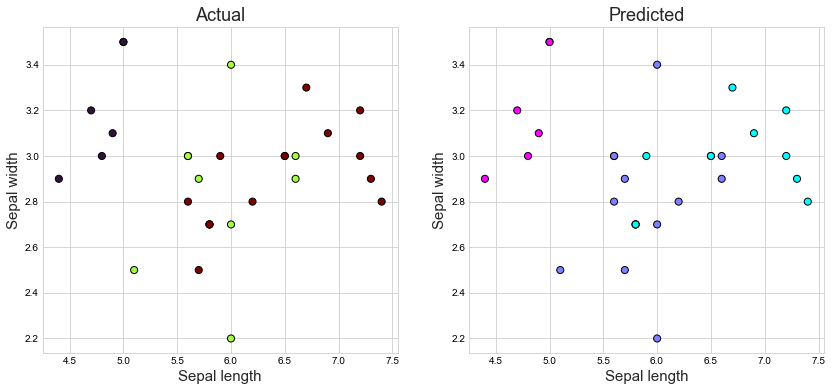

In [53]:
# Plot the identified clusters and compare with the answers
sns.set_style("whitegrid");
fig, axes = plt.subplots(1, 2, figsize=(14,6))
axes[0].scatter(test_x[:, 0], test_x[:, 1], c=test_y, cmap='turbo', edgecolor='k', s=50)
axes[1].scatter(test_x[:, 0], test_x[:, 1], c=pred_ty, cmap='cool_r', edgecolor='k', s=50)
axes[0].set_xlabel('Sepal length', fontsize=15)
axes[0].set_ylabel('Sepal width', fontsize=15)
axes[1].set_xlabel('Sepal length', fontsize=15)
axes[1].set_ylabel('Sepal width', fontsize=15)
axes[0].tick_params(direction='in', length=10, width=5, colors='k', labelsize=10)
axes[1].tick_params(direction='in', length=10, width=5, colors='k', labelsize=10)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('Predicted', fontsize=18)

### Finally, let’s implement all these steps using the sklearn library so that we can compare the results:

In [54]:
#lets implement the same algorithm using sklearn libraries
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
#train
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
kmeans.fit(train_x)
  

KMeans(n_clusters=3, random_state=42)

In [55]:
# Predict

y_kmeans_bulitin = kmeans.fit_predict(test_x)
y_kmeans_bulitin

array([0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1,
       2, 1, 0, 1, 1, 0, 1, 2])

Text(0.5, 1.0, 'Predicted')

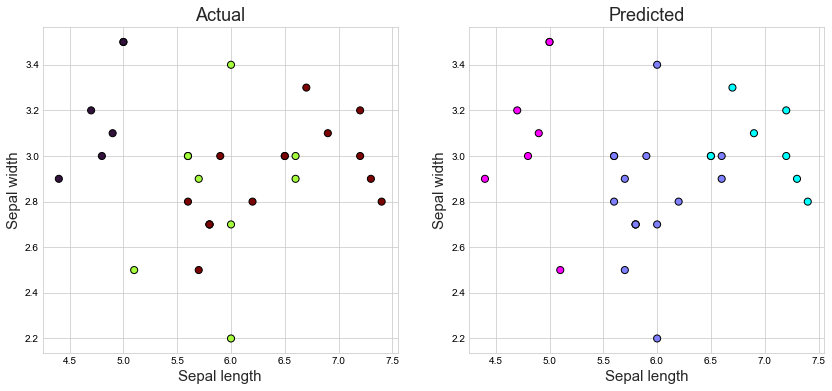

In [56]:
# Plot the identified clusters and compare with the answers
sns.set_style("whitegrid");
fig, axes = plt.subplots(1, 2, figsize=(14,6))
axes[0].scatter(test_x[:, 0], test_x[:, 1], c=test_y, cmap='turbo', edgecolor='k', s=50)
axes[1].scatter(test_x[:, 0], test_x[:, 1], c=y_kmeans_bulitin, cmap='cool_r', edgecolor='k', s=50)
axes[0].set_xlabel('Sepal length', fontsize=15)
axes[0].set_ylabel('Sepal width', fontsize=15)
axes[1].set_xlabel('Sepal length', fontsize=15)
axes[1].set_ylabel('Sepal width', fontsize=15)
axes[0].tick_params(direction='in', length=10, width=5, colors='k', labelsize=10)
axes[1].tick_params(direction='in', length=10, width=5, colors='k', labelsize=10)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('Predicted', fontsize=18)